In [1]:
#Importing all the libraries
using SpecialFunctions
using LinearAlgebra
using DataFrames
using StatsPlots
using ProgressMeter
using CSV
theme(:dao)
ProgressMeter.ijulia_behavior(:clear)

function scurve(x)  #Function for an S shaped curve, used inside survival function
    return 1/(1 + exp(-11 * (x - 0.5)))
end

scurve (generic function with 1 method)

In [2]:
global DOMINANT = false        #Switch between 1 being dominant or recessive
SHAPE = "linear"                  #Shape of survival function

P = Dict(
    "pm" => 0.01,       #Proportion of 1 for male locus
    "pf" => 0.01,       #Proportion of 1 for female locus
    "C" => 20,          #Eggs laid by non functionender females
    "c" => 14,          #Eggs laid by functionender females
    "a" => 2,           #Advantege for non functionender males
    "u" => 0.1,         #Probability of female staying unmated
    "r" => 0.1          #Ratio of males in a female male mating
    )

function s(d, use = "exp")      #Probability of survival given the proportion of functionenders in the offsprings
    if use == "linear"
        return d * (0.9 - 0.1) + 0.1
    elseif use == "expinv"
        return ((exp(-d * 2.5) - exp(0))/(exp(-1 * 2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "exp"
        return ((exp(2.5*d) - exp(0))/(exp(2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "s"
        return ((scurve(d) - scurve(0)) / (scurve(1) - scurve(0))) * (0.9 - 0.1) + 0.1
    elseif use == "relu"
        return minimum(0.9, maximum(0.1, d^1.5))
    end
end

s (generic function with 2 methods)

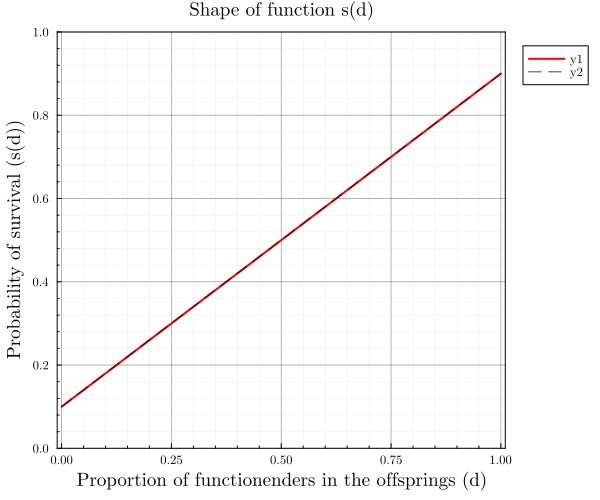

In [3]:
#Plotting the shape of survival function
d = range(0, stop=1, length=101)
plot(d, s.(d, SHAPE), lw = 2, lc=:red, size = (600,500))
plot!(d, range(0.1, stop=0.9, length=101), linestyle=:dash, color=:black, alpha=0.5, lw = 1.5)
xlims!(-0.01,1.01)
ylims!(0.0, 1)
xlabel!("Proportion of functionenders in the offsprings (d)")
ylabel!("Probability of survival (s(d))")
title!("Shape of function s(d)")

In [4]:
#Modular functions for different loops
function F(u, f, m, c, S) #Calculating the overall numberr of offsprings
    return u * f * m * c * S
end

function S1(c, r)
    k = collect(0:c)
    S = sum(binomial.(c, k) .* (((r).^k).*((1-r).^(c.-k))) .* s.(k/c, SHAPE))
    return S
end

function S2(c, r1, r2, case = 1)
    if case == 1
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.(m/c, SHAPE))
            S +=  mul1 * Sm
        end
    elseif case == 2
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.((m .+ (c - k))/c, SHAPE))
            S +=  mul1 * Sm
        end
    end
    return S
end

function S3(c, r1, r2, r3)
    S = 0
    for k in 0:c
        mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
        for m in 0:k
            mul2 = binomial.(k, m) * (((r2).^m).*((1-r2).^(k-m)))
            f = collect(0:c-k)
            Sf = sum(binomial.(c-k, f) .* (((r3).^f).*((1-r3).^(c-k.-f))) .* s.((f.+m)/c, SHAPE))
            S += mul1 * mul2 * Sf
        end
    end
    return S
end

S3 (generic function with 1 method)

In [5]:
#Defining all interactions and offsprings
#Non matings
function f00(P) #Results: M0 (1)    
    return F(P["u"], P["f00"], 1, P["C"], s(0, SHAPE))
end

function f01(P) #Results: M0 (0.5), M1 (0.5)
    return F(P["u"], P["f01"], 1, DOMINANT ? P["c"] : P["C"], S1(DOMINANT ? P["c"] : P["C"], 0.5))
end

function f11(P) #Results M1 (1)
    return F(P["u"], P["f11"], 1, P["c"], s(1, SHAPE))
end


#Matings
function f00m0(P) #Results: F00 (1-r), M0 (r)
    return F(1 - P["u"], P["f00"], P["m0"], P["C"], s(0, SHAPE))
end

function f11m1(P) #Results: F11 (1-r), M1 (r)
    return F(1 - P["u"], P["f11"], P["m1"], P["c"], s(1, SHAPE))
end

function f00m1(P) #Results: F01 (1-r), M0 (r)
    return F(1 - P["u"], P["f00"], P["m1"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f11m0(P) #Results: F01 (1-r), M1(r)
    return F(1 - P["u"], P["f11"], P["m0"], P["c"], DOMINANT ? s(1, SHAPE) : S1(P["c"], P["r"]))
end

function f01m0(P) #Results: F01 (1-r * 0.5), F00 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    return F(1 - P["u"], P["f01"], P["m0"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S3(P["c"], P["r"], 0.5, 0.5) : S2(P["C"], P["r"], 0.5, 1))
end

function f01m1(P) #Results: F01 (1-r * 0.5), F11 (1-r * 0.5), M1 (r * 0.5), M0 (r * 0.5)
    return F(1 - P["u"], P["f01"], P["m1"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], P["r"], 0.5, 2) : S3(P["C"], P["r"], 0.5, 0.5))
end

f01m1 (generic function with 1 method)

In [6]:
#Function to find the number of offsprings in the next generation based on all the interactions
function nexgen(P, females = [], males = [])

    #Initial frequencies of all genotypes
    if length(females) == 0 || length(males) == 0
        #Males
        m0 = (1 - P["pm"])
        m1 = P["pm"]
        
        tot_eff = m1 + (P["a"] * m0)

        P["m0"] = (P["a"] * m0) / tot_eff
        P["m1"] = m1 / tot_eff

        #Females (Assuming equilibrium values)
        P["f00"] = (1 - P["pf"])^2
        P["f01"] = 2 * P["pf"] * (1 - P["pf"])
        P["f11"] = P["pf"]^2


    else
        #Males
        m0 = males[1]
        m1 = males[2]

        tot_eff = m1 + (P["a"] * m0)

        P["m0"] = (P["a"] * m0) / tot_eff
        P["m1"] = m1 / tot_eff
        
        #Females (Assuming equilibrium values)
        P["f00"] = females[1]
        P["f01"] = females[2]
        P["f11"] = females[3]
    end

    #New generation
    #Males
    m0_n = f00(P) + 0.5 * f01(P) + P["r"] * (f00m0(P) + f00m1(P) + 0.5 * (f01m0(P) + f01m1(P)))

    m1_n = f11(P) + 0.5 * f01(P) + P["r"] * (f11m1(P) + f11m0(P) + 0.5 * (f01m0(P) + f01m1(P)))

    #Females
    f00_n = (1 - P["r"]) * (f00m0(P) + (0.5) * f01m0(P))

    f01_n = (1 - P["r"]) * (f00m1(P) + f11m0(P) + 0.5 * (f01m0(P) + f01m1(P)))

    f11_n = (1 - P["r"]) * (f11m1(P) + (0.5) * f01m1(P))
    

    #Creating a list for number of all organisms in next generation
    female_ls = [f00_n, f01_n, f11_n]
    male_ls = [m0_n, m1_n]

    return female_ls, male_ls
end

nexgen (generic function with 3 methods)

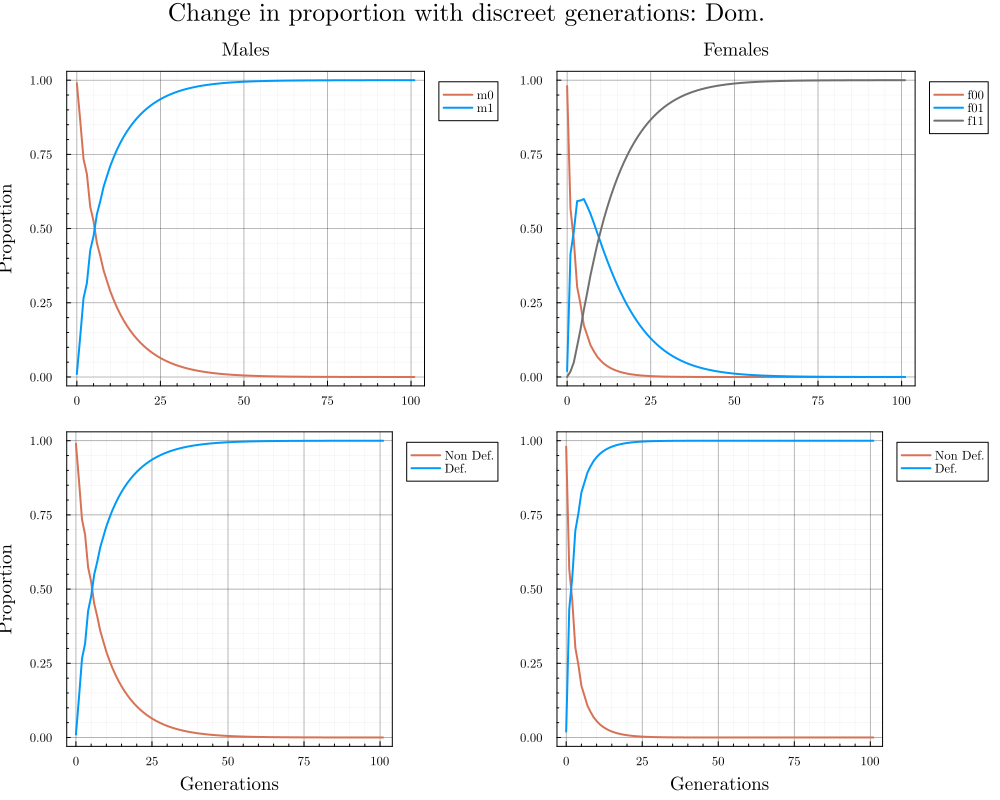

In [16]:
#Simulating proportions of each individual over a generation time
DOMINANT = true   #This simulation is for the recessive case
SHAPE = "s"      #Shape for the survival function being used is exponential
gentime = 100

param = copy(P)    #Copying the main param dictionary to avoid making any changes to it
param["pm"] = 0.1
param["pf"] = 0.1

param["c"] = 7
param["a"] = 1

param["u"] = 0.1
param["r"] = 0.475

females = []
males = []

ind_prop = Dict(      #Dictionary storing the proportion of indivduals at each generation
    "m0" => [1 - P["pm"]],
    "m1" => [P["pm"]],
    
    "f00" => [(1 - P["pf"])^2],
    "f01" => [P["pf"] * (1 - P["pf"]) * 2],
    "f11" => [P["pf"]^2],
    )

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m0"], male_ls[1] / sum(male_ls))
    push!(ind_prop["m1"], male_ls[2] / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[3] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["m0" "m1"], lw = 2, ylabel = "Proportion", title = "Males")
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f11"]], labels = ["f00" "f01" "f11"], lw = 2, title = "Females")
p3 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"]) ind_prop["f11"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [ind_prop["f00"] (ind_prop["f01"] .+ ind_prop["f11"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

plot(p1, p2, p3, DOMINANT ? pdom : prec, layout = (2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations: ", DOMINANT ? "Dom." : "Rec."))

#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#

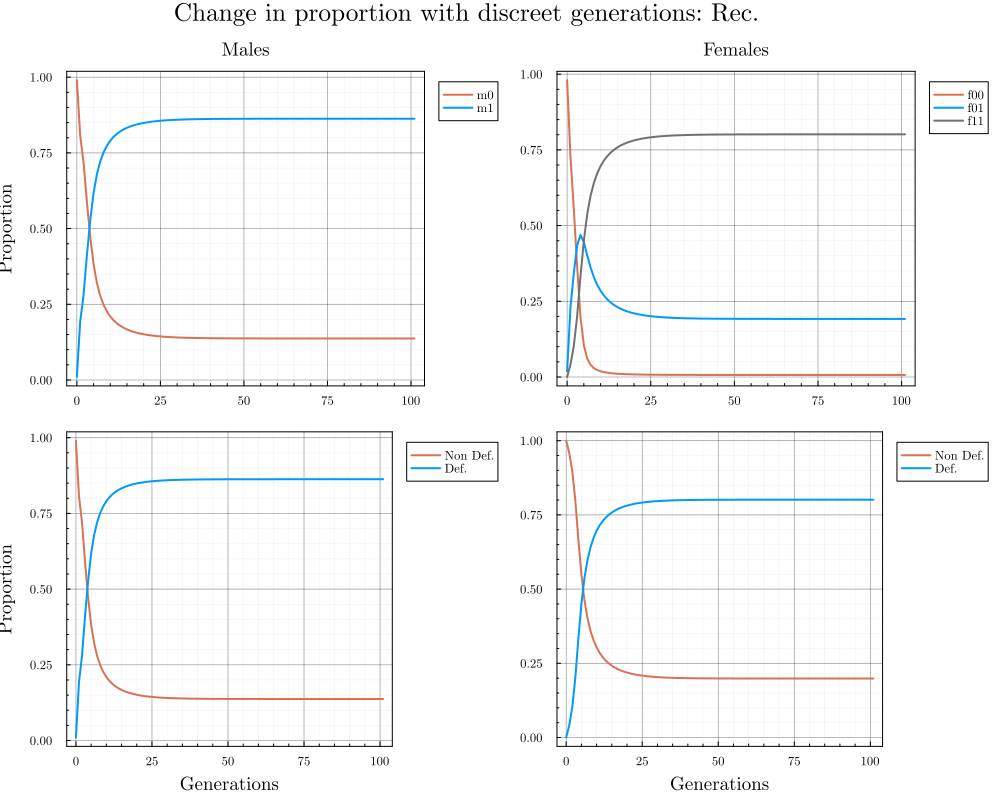

In [17]:
#Simulating proportions of each individual over a generation time
DOMINANT = false   #This simulation is for the recessive case
SHAPE = "s"      #Shape for the survival function being used is exponential
gentime = 100

param = copy(P)    #Copying the main param dictionary to avoid making any changes to it
param["pm"] = 0.1
param["pf"] = 0.1

param["c"] = 7
param["a"] = 1

param["u"] = 0.1
param["r"] = 0.475

females = []
males = []

ind_prop = Dict(      #Dictionary storing the proportion of indivduals at each generation
    "m0" => [1 - P["pm"]],
    "m1" => [P["pm"]],
    
    "f00" => [(1 - P["pf"])^2],
    "f01" => [P["pf"] * (1 - P["pf"]) * 2],
    "f11" => [P["pf"]^2],
    )

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m0"], male_ls[1] / sum(male_ls))
    push!(ind_prop["m1"], male_ls[2] / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[3] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["m0" "m1"], lw = 2, ylabel = "Proportion", title = "Males")
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f11"]], labels = ["f00" "f01" "f11"], lw = 2, title = "Females")
p3 = plot(rng, [ind_prop["m0"] ind_prop["m1"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"]) ind_prop["f11"]], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [ind_prop["f00"] (ind_prop["f01"] .+ ind_prop["f11"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

plot(p1, p2, p3, DOMINANT ? pdom : prec, layout = (2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations: ", DOMINANT ? "Dom." : "Rec."))

#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#

In [7]:
function prop_plot(P) #Function to produce dataframes of defender proportion with varying costs (c and alpha)
    range_c = collect(1:1:20)
    range_a = round.(collect(range(1, 3, 20)), digits = 2)

    param = copy(P)
    param["pm"] = 0.1
    param["pf"] = 0.1

    param["u"] = 0.1
    param["r"] = 0.2

    gentime = 200

    female_data = DataFrame([name => Float64[] for name in string.(20./range_c)])
    male_data = DataFrame([name => Float64[] for name in string.(20./range_c)])
    total_data = DataFrame([name => Float64[] for name in string.(20./range_c)])

    for i in range_a
        female_data_a = []
        male_data_a = []
        total_data_a = []

        param["a"] = i
        for j in range_c
            param["c"] = j

            females = []
            males = []
            
            female_ls = []
            male_ls = []
            for t in 0:gentime
                females, males = nexgen(param, female_ls, male_ls)

                female_ls = copy(females)
                male_ls = copy(males)

                female_ls = female_ls ./ (sum(female_ls))
                male_ls = male_ls ./ (sum(male_ls))
            end
                    
            if DOMINANT
                total_def = (males[2] + sum(females[2:end])) / (sum(males) + sum(females))
                male_def = males[2] / sum(males)
                female_def = sum(females[2:end]) / sum(females)
            else
                total_def = (males[2] + females[3]) / (sum(males) + sum(females))
                male_def = males[2] / sum(males)
                female_def = females[3] / sum(females)
            end
                
            push!(female_data_a, female_def)
            push!(male_data_a, male_def)
            push!(total_data_a, total_def)
        
        end
        push!(female_data, female_data_a)
        push!(male_data, male_data_a)
        push!(total_data, total_data_a)
    
    end

    return female_data, male_data, total_data
end

prop_plot (generic function with 1 method)

In [9]:
shapes = ["s", "linear", "exp", "expinv"] #Running the function through all shapes and for both dominant and recessive cases, saving the output as csv
filepath = "C:/project/Masters_2023_DrHannaK/DataCSVs/"

@showprogress 1 "Computing..." for i in 2:2
    SHAPE = shapes[i]
    DOMINANT = true
    f_dom, m_dom, t_dom = prop_plot(P)
    DOMINANT = false
    f_rec, m_rec, t_rec = prop_plot(P)

    CSV.write(string(filepath, "BM_f_dom_u1r2_", SHAPE,".csv"), f_dom)
    CSV.write(string(filepath, "BM_m_dom_u1r2_", SHAPE,".csv"), m_dom)
    CSV.write(string(filepath, "BM_t_dom_u1r2_", SHAPE,".csv"), t_dom)
    CSV.write(string(filepath, "BM_f_rec_u1r2_", SHAPE,".csv"), f_rec)
    CSV.write(string(filepath, "BM_m_rec_u1r2_", SHAPE,".csv"), m_rec)
    CSV.write(string(filepath, "BM_t_rec_u1r2_", SHAPE,".csv"), t_rec)
end